In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
ROOT_DIR = '.'
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
DATA_DIR = os.path.join(ROOT_DIR, 'data')
MODEL_DIR = os.path.join(ROOT_DIR, 'models')
def save_fig(img_name, fig_extension="png", res=300, verbose = False ):
    path = os.path.join(IMAGE_DIR, img_name + "." + fig_extension)
    if verbose:
        print("Saving figure", img_name)
    plt.savefig(path, format=fig_extension, dpi=res)

- 1. EDA: 
    - corr matrix
    - scatter plot
    - ourlier search
    - geo graph for latitude (color point by price)
- 2. Modelling:     
    cross val check, grid search 
    - Linear regression with polynomals + lasso/elastic
    - quick SVM check (del later? +branch)
    - Random Forrest + corssval (and test oob) gridsearch
    - XGBoost Regression test!!!!
    - what other algorithm can be used? 
    - try a few neuron nets to get better results

In [4]:
data_path = DATA_DIR + '\\sao-paulo-properties-april-2019.csv'
data = pd.read_csv(data_path)

In [7]:
data.head(2)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718


### what does the Condo columns do???!!!

In [64]:
target = ['Price']
cat_cols = ['District']
drop_cols = ['Negotiation Type', 'Property Type', 'Condo']
num_cols = [c for c in data.columns if c not in cat_cols + drop_cols]

sale_data = data[data['Negotiation Type'] == 'sale'].drop(drop_cols + cat_cols, axis=1).copy()
rent_data = data[data['Negotiation Type'] == 'rent'].drop(drop_cols+ cat_cols, axis=1).copy()

In [65]:
data.isna().any()

Price               False
Condo               False
Size                False
Rooms               False
Toilets             False
Suites              False
Parking             False
Elevator            False
Furnished           False
Swimming Pool       False
New                 False
District            False
Negotiation Type    False
Property Type       False
Latitude            False
Longitude           False
dtype: bool

In [66]:
sale_data.shape, rent_data.shape

((6412, 12), (7228, 12))

Saving figure Corr Heatmap


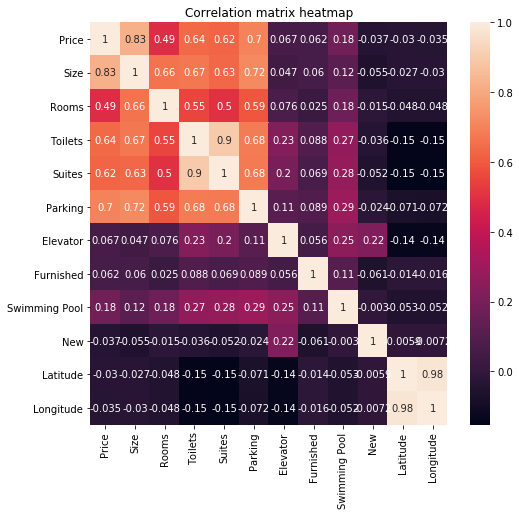

In [67]:
corr_matrix = sale_data.corr()
plt.figure(figsize=(8,7.4))
sns.heatmap(corr_matrix, annot = True)
plt.title('Correlation matrix heatmap')
save_fig('Corr Heatmap', verbose = True)
plt.show()

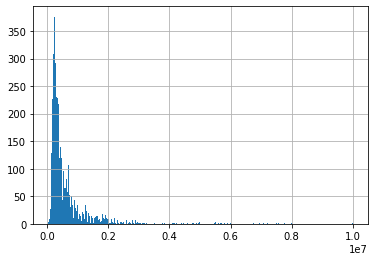

In [68]:
sale_data.Price.hist(bins=500)

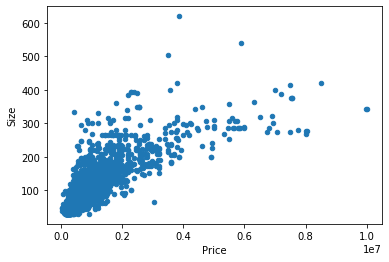

In [77]:
sale_data.plot.scatter('Price','Size')

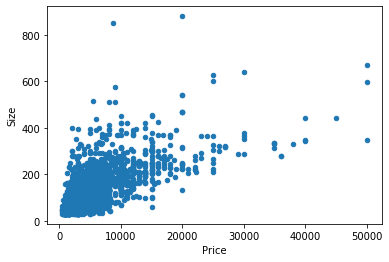

In [160]:
rent_data.plot.scatter('Price','Size')

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import a

In [79]:
sale_data[ sale_data.Price > 400000 ]

,Price,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
4901,732600,74,1,2,1,2,1,0,1,0,-23.552129,-46.692244
4902,1990000,164,4,5,2,3,1,1,1,0,-23.551613,-46.699106
4903,720000,70,2,2,1,1,1,0,1,1,-23.547687,-46.692594
4904,1680000,155,3,5,3,2,1,0,1,0,-23.552590,-46.691104
4905,1200000,56,2,2,1,2,0,1,1,0,-23.553087,-46.697890
...,...,...,...,...,...,...,...,...,...,...,...,...
13629,995000,102,3,2,1,2,0,0,1,0,-23.634710,-46.636334
13632,800000,86,3,2,1,2,0,0,1,0,-23.647569,-46.641989
13634,456000,85,3,1,0,1,0,0,0,0,-23.773509,-46.675631
13636,545000,74,3,2,1,2,0,0,1,0,-23.648930,-46.641982


In [81]:
def run_n_evaluate_model(X, y, model, cv=10, return_fitted = False):
    def r(num):
        return np.round(num,3)
    scores = cross_validate(model, X, y, cv = cv, return_train_score= True,
                            scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']  )
    print(model)
    print('Test avg cros_val scores:\nMAE: {} \nMSE: {}\nR2 score: {}'.format(r(scores['test_neg_mean_absolute_error'].mean()*-1),
                                                                            r(scores['test_neg_root_mean_squared_error'].mean()*-1),
                                                                            r(scores['test_r2'].mean()) ))
    print('---------------')
    print('Train avg cros_val scores::\nMAE: {} \nRMSE: {}\nR2 score: {}'.format(r(scores['train_neg_mean_absolute_error'].mean()*-1),
                                                                                r(scores['train_neg_root_mean_squared_error'].mean()*-1),
                                                                                r(scores['train_r2'].mean()) ))
    if return_fitted:
        return model.fit(X,y)

In [161]:
import src.evaluation as ev

In [ ]:
import importlib.reload
reload(ev)

In [207]:
def scores_mean(scores):
    s_mean = np.round(scores.mean(),3).unstack()
    #s_mean.apply(lambda x: -1*x if x < 0 else x)
    return s_mean

In [162]:
#sale_df_max = sale_data[ sale_data.Price < 400000 ]
y = sale_data[target]
X = sale_data.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 64)

In [192]:
lin_reg = LinearRegression()

scores = ev.get_cros_val_scores(lin_reg, X_train, y_train)
np.round(scores.mean(),3).unstack().style.format('{0:,}')

score,neg_mean_absolute_error,neg_root_mean_squared_error,r2
set,,,
test,"-195,685.77","-394,936.435",0.721
train,"-194,756.093","-393,632.592",0.727


In [208]:
s

score,neg_mean_absolute_error,neg_root_mean_squared_error,r2
set,,,
test,"-195,685.77","-394,936.435",0.721
train,"-194,756.093","-393,632.592",0.727


In [212]:
s = scores_mean(scores)
s['neg_mean_absolute_error'].apply(lambda x: -1*x if x < 0 else x)

set
test     195685.770
train    194756.093
Name: neg_mean_absolute_error, dtype: float64

In [85]:
lin_reg = LinearRegression()
run_n_evaluate_model(X_train, y_train, lin_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Test avg cros_val scores:
MAE: 195685.77 
MSE: 394936.435
R2 score: 0.721
---------------
Train avg cros_val scores::
MAE: 194756.093 
RMSE: 393632.592
R2 score: 0.727


In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

In [89]:
run_n_evaluate_model(X_train_poly, y_train, lin_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Test avg cros_val scores:
MAE: 179188.832 
MSE: 472157.374
R2 score: 0.456
---------------
Train avg cros_val scores::
MAE: 164099.311 
RMSE: 343680.099
R2 score: 0.791


In [101]:
lasso = Lasso(alpha=10, normalize=True)
run_n_evaluate_model(X_train_poly, y_train, lasso)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)
Test avg cros_val scores:
MAE: 170384.91 
MSE: 368241.647
R2 score: 0.756
---------------
Train avg cros_val scores::
MAE: 165762.257 
RMSE: 347494.517
R2 score: 0.787


In [115]:
forrest = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=35)
run_n_evaluate_model(X_train, y_train, forrest)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=35,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Test avg cros_val scores:
MAE: 155867.563 
MSE: 301002.931
R2 score: 0.831
---------------
Train avg cros_val scores::
MAE: 138915.369 
RMSE: 228639.84
R2 score: 0.908


In [113]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha=0.0001, l1_ratio= 0.9, normalize=True)
run_n_evaluate_model(X_train_poly, y_train, elastic)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Test avg cros_val scores:
MAE: 172486.144 
MSE: 367478.647
R2 score: 0.757
---------------
Train avg cros_val scores::
MAE: 169473.181 
RMSE: 355312.064
R2 score: 0.777


In [158]:
from sklearn.ensemble import RandomForestRegressor
rforrest = RandomForestRegressor(n_estimators= 10,criterion='mse', 
                                    max_depth=10, 
                                    max_leaf_nodes=40,
                                     max_features='auto', 
                                     min_samples_leaf=10)
run_n_evaluate_model(X_train, y_train, rforrest)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=40,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Test avg cros_val scores:
MAE: 139898.967 
MSE: 295541.233
R2 score: 0.84
---------------
Train avg cros_val scores::
MAE: 126920.773 
RMSE: 259360.463
R2 score: 0.881


In [159]:
rforrest.fit(X_train, y_train)
rforrest.feature_importances_, sale_data.columns


(array([8.27555913e-01, 1.39460949e-03, 2.10339404e-03, 3.27248294e-03,
        4.20357557e-02, 8.45551954e-05, 0.00000000e+00, 1.13052358e-03,
        0.00000000e+00, 2.22355241e-02, 1.00187242e-01]),
 Index(['Price', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator',
        'Furnished', 'Swimming Pool', 'New', 'Latitude', 'Longitude'],
       dtype='object'))

# Try randomforrest OOB SCORE for evaluation

Sale date result with whole dataset
    Test avg cros_val scores:\n
    MAE: 190101.535 
    MSE: 390035.695
    R2 score: 0.728
    Train avg cros_val scores::
    MAE: 188937.5 
    RMSE: 388340.397
    R2 score: 0.734

In [83]:
y = rent_data[target]
X = rent_data.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 64)

lin_reg = LinearRegression()
run_n_evaluate_model(X_train, y_train, lin_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Test avg cros_val scores:
MAE: 1154.048 
MSE: 2227.2
R2 score: 0.61
---------------
Train avg cros_val scores::
MAE: 1149.765 
RMSE: 2237.184
R2 score: 0.615
